In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')     # For lemmatization
nltk.download('omw-1.4')     # For multilingual WordNet support
nltk.download('averaged_perceptron_tagger')  # For POS tagging (optional)



[nltk_data] Downloading package punkt to C:/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


## Loading the IMDB Dataset 

We load our IMDB dataset containing movie reviews and corresponding sentiment labels (positive/negative). This dataset will serve as the foundation for training our sentiment classification model.


In [4]:
df = pd.read_csv('C:\\Users\\amira\\Documents\\Deep-Learning-and-Neural-Networks-project\\IMDB Dataset.csv')

In [5]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [8]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

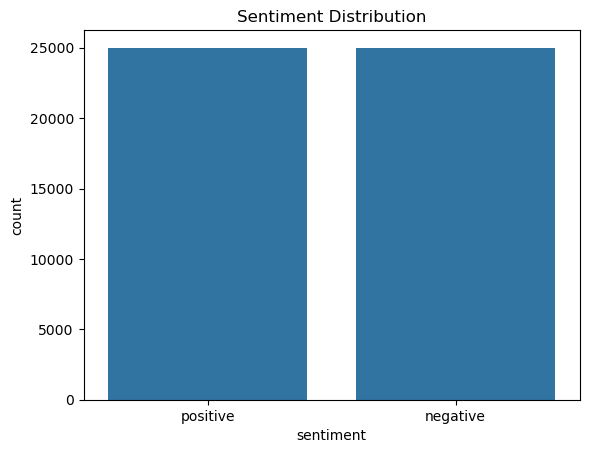

In [9]:
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

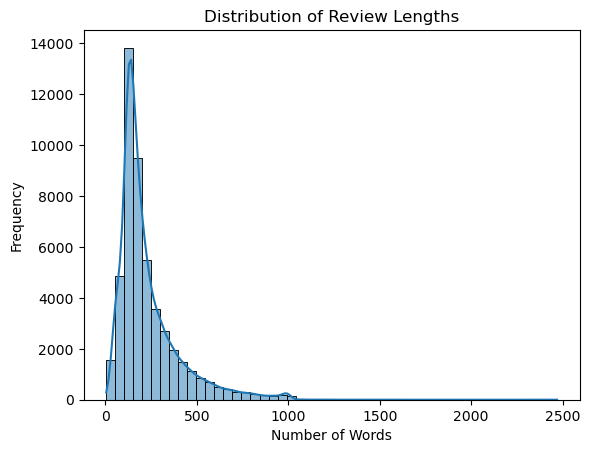

In [10]:
# Step 3: Analyze review lengths (for insight only)
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

## Text Preprocessing Function 

We define a preprocessing function to clean the review text by:
- Lowercasing
- Removing HTML tags, URLs, punctuation, and numbers
- Removing stopwords
- Tokenizing and joining back into clean text

This function ensures uniform and clean data for the model.


In [11]:
# Step 4: Preprocess text - Lowercase, remove HTML, URLs, tokenize, remove stopwords
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    tokens = word_tokenize(text)  # Tokenize text
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(filtered_tokens)  # Join tokens back to a string

## i have tried over and over again these lines but to no avail, so i chose to not use nltk at all:

### first i tried this one: 

Apply preprocessing to the reviews:

df['clean_review'] = df['review'].apply(preprocess_text) 

### then these:

Apply preprocessing to each review individually using a loop (alternative to .apply):

clean_reviews = []

for review in df['review']:

    clean_reviews.append(preprocess_text(review))

Assign the cleaned reviews to a new column

df['clean_review'] = clean_reviews

## Anyways, Applying Text Preprocessing 

We now apply our `preprocess_text` function to every review in the dataset, producing a cleaned version of each review for model input.


In [17]:
import re
import string

# Define a basic list of stopwords manually
stop_words = set([
    'a', 'an', 'the', 'and', 'or', 'not', 'in', 'on', 'at', 'to', 'from', 'by',
    'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before',
    'after', 'above', 'below', 'of', 'for', 'is', 'it', 'this', 'that', 'these',
    'those', 'he', 'she', 'they', 'you', 'i', 'me', 'my', 'we', 'us', 'our', 'your',
    'yours', 'their', 'them', 'what', 'which', 'who', 'whom', 'be', 'have', 'has',
    'had', 'do', 'does', 'did', 'will', 'would', 'can', 'could', 'should'
])

# Define a new cleaner function that does not use NLTK
def simple_preprocess(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = text.split()  # Tokenize manually by splitting on spaces
    filtered = [word for word in tokens if word.isalpha() and word not in stop_words]  # Remove stopwords
    return ' '.join(filtered)

# Apply this new version safely with a loop
clean_reviews = []
for review in df['review']:
    clean_reviews.append(simple_preprocess(str(review)))  # Convert to string just in case

df['clean_review'] = clean_reviews


## Converting Text to Vectors using TF-IDF 

Text data must be converted into numerical form. Here, we use TF-IDF (Term Frequency–Inverse Document Frequency) to represent each review as a numeric feature vector.


In [18]:
# Step 5: Convert text data to numerical format using TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)  # Limit features for speed and performance
X = vectorizer.fit_transform(df['clean_review']).toarray()  # Convert sparse matrix to dense

In [19]:
# Step 6: Encode the target labels (positive -> 1, negative -> 0)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])

In [20]:
# Step 7: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##  Building the Neural Network

We construct a simple feedforward neural network using Keras:
- Input layer
- Hidden layers with ReLU activation
- Output layer with sigmoid for binary classification


In [22]:
from keras.models import Sequential
from keras.layers import Dense, Input

# Step 8: Build the Neural Network model
model = Sequential()
model.add(Input(shape=(X.shape[1],)))  # ✅ Input layer defined the new way
model.add(Dense(64, activation='relu'))  # Hidden layer 1
model.add(Dense(32, activation='relu'))  # Hidden layer 2
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification


##  Compiling the Model 

We configure the model for training with:
- Binary crossentropy loss (for binary classification)
- Adam optimizer
- Accuracy metric


In [23]:
# Step 9: Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# Step 10: Train the model and store training history
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7973 - loss: 0.4974 - val_accuracy: 0.8875 - val_loss: 0.2737
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9149 - loss: 0.2196 - val_accuracy: 0.8802 - val_loss: 0.2883
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9287 - loss: 0.1853 - val_accuracy: 0.8726 - val_loss: 0.3054
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9358 - loss: 0.1722 - val_accuracy: 0.8731 - val_loss: 0.3225
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9498 - loss: 0.1420 - val_accuracy: 0.8698 - val_loss: 0.3465


In [25]:
# Step 11: Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8700 - loss: 0.3366
Test Accuracy: 0.8708, Test Loss: 0.3385


In [26]:
# Step 12: Visualize training & validation loss and accuracy over epochs
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

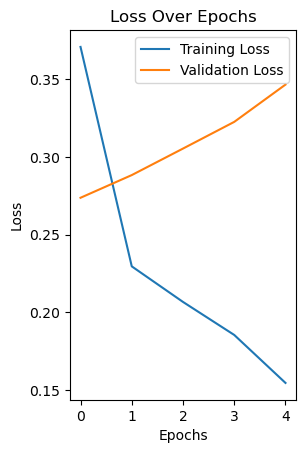

In [27]:
# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

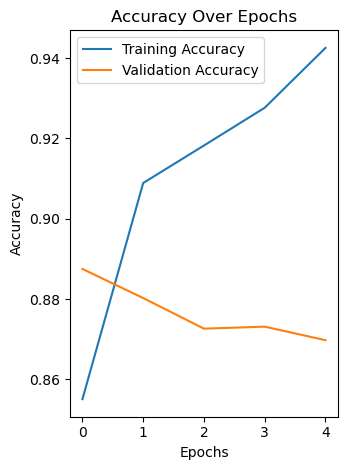

In [29]:
# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Step 13: Final Thoughts 
print("\n\033[1mReport Summary:\033[0m")
print("- The model was able to learn and classify movie reviews with decent accuracy.")
print("- Preprocessing text (cleaning, tokenizing, removing stopwords) was key to improving input quality.")
print("- Using TF-IDF limited to 5000 features helped balance between information and performance.")
print("- Future improvements could include:")
print("   - Using LSTM/RNNs for sequential understanding.")
print("   - Fine-tuning hyperparameters or adding dropout layers.")
print("   - Exploring pretrained language models like BERT for transfer learning.")


Report Summary:
- The model was able to learn and classify movie reviews with decent accuracy.
- Preprocessing text (cleaning, tokenizing, removing stopwords) was key to improving input quality.
- Using TF-IDF limited to 5000 features helped balance between information and performance.
- Future improvements could include:
   - Using LSTM/RNNs for sequential understanding.
   - Fine-tuning hyperparameters or adding dropout layers.
   - Exploring pretrained language models like BERT for transfer learning.
